In [2]:
from math import gcd 
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
from datetime import datetime
import copy as cp

import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error
import qiskit.ignis.verification.randomized_benchmarking as rb

qiskit.__version__, sys.version

('0.19.1',
 '3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)]')

# Library

In [663]:
def add_qudi_gate(qc, qd_gate, swap_qubits=False, mirror_1q=False):
    gate_str = qd_gate[0][0]
    gate_params = qd_gate[0][1]
    qubit = qd_gate[1]
    
    if swap_qubits:
        if len(qubit) == 1:
            qubit = [1] if qubit == [0] else [0]
        elif len(qubit) == 2:
            qubit = list(reversed(qubit))
        else:
            raise NotImplemented
    
    if mirror_1q:
        # todo: broken. not correct qiskit quantumreg
        if len(qubit) != 1:
            raise ValueError
        else:
            qubit = [0,1]
    
    if gate_str == 'rx':
        qc.rx(gate_params[0], qubit)
    elif gate_str == 'ry':
        qc.ry(gate_params[0], qubit)
    elif gate_str == 'cx':
        #pass
        qc.cx(qubit[1], qubit[0])
    elif gate_str == 'barrier':
        qc.barrier(qubit)
    elif gate_str == 'measure':
        qc.measure(qubit, 0)
    else:
        raise NotImplemented

def filter_same_n_cnot(rb_circs):
    rb_circs_filtered = []
    n_clif_vec = len(rb_circs)
    for i in range(0, n_clif_vec):
        circs_i = []

        n_cnots = [get_n_cx(c) for c in rb_circs[i]]
        most_common = max(set(n_cnots), key = n_cnots.count)
        n_cnots_target = most_common
                
        filtered = filter(lambda c: get_n_cx(c) == n_cnots_target, rb_circs[i])
        rb_circs_filtered.append(list(filtered))
    return rb_circs_filtered

def filter_gate(rb_circs, filter_gate='cx'):
    qregs = rb_circs[0][0].qregs
    cregs = rb_circs[0][0].cregs
        
    rb_circs_filtered = []
    n_clif_vec = len(rb_circs)
    circs_i = []
    for i in range(0, n_clif_vec):
        circs_j = []
        for j in range(0, len(rb_circs[i])):
            #circs_j.append([gate for gate in rb_circs[i][j].data if not gate[0].name == filter_gate])
            qc = qiskit.QuantumCircuit(*qregs, *cregs)
            for i in circ:
                if i[0].name != filter_gate:
                    qc.data.append(i)
                    
            circs_j.append(qc)            
        circs_i.append(circs_j)
        
    return circs_i

def clip_same_n_rand(rb_circs):
    n_rand = [len(circs) for circs in rb_circs]
    min_n = np.min(n_rand)
    
    rb_circs_out = []
    
    for i in range(0, len(rb_circs)):
        rb_circs_rand = []
        for j in range(0, min_n):
            rb_circs_rand.append(rb_circs[i][j])
        rb_circs_out.append(rb_circs_rand)

    return rb_circs_out

def calc_cx(rb_circs):
    # calculate number of cnots per xdata step
    arr = np.zeros((len(rb_circs),len(rb_circs[0])))
    for i in range(0, len(rb_circs)):
        for j in range(0, len(rb_circs[0])):
            arr[i,j] = get_n_cx(rb_circs[i][j])
    return arr

def calc_1q(rb_circs, basis_gates=['ry', 'rx']):
    # calculate number of cnots per xdata step
    arr = np.zeros((len(rb_circs),len(rb_circs[0])))
    for i in range(0, len(rb_circs)):
        for j in range(0, len(rb_circs[0])):
            arr[i,j] = get_n_1q_rot(rb_circs[i][j], basis_gates=basis_gates)
    return arr

def get_n_cx(circ):
    if type(circ) == list:
        # after conversion to qudi format
        return np.sum([el[0][0]=='cx' for el in circ[1]])
    
    return np.sum([el[0].name=='cx' for el in circ.data])

def get_n_1q_rot(circ, basis_gates=['ry', 'rx']):
    if type(circ) == list:
        # after conversion to qudi format
        return np.sum([el[0][0] in basis_gates for el in circ[1]])
    
    elif type(circ) == qiskit.circuit.quantumcircuit.QuantumCircuit:
        return np.sum([el[0].name in basis_gates for el in circ.data])

    raise ValueError 


def is_interleaved(rb_opts):
    if 'interleaved_gates' not in rb_opts:
        return False
    return rb_opts['interleaved_gates'] != []

def circuit_step_2_qubit_idx(cstep, swap_qubits=False):
    qregister = cstep[1]
    if len(qregister) == 2:
        return [0,1]
    elif len(qregister) == 1:
        reg_str = str(qregister[0])
        if ", 1" in reg_str:
            return [1] if not swap_qubits else [0]
        elif ", 0" in reg_str:
            return [0] if not swap_qubits else [1]
    elif len(qregister) > 2:
        raise NotImplementedError

def circuit_step_2_gatestr(cstep):
    return cstep[0].name, [float(p) for p in cstep[0].params]

def circuit_2_step_list(circ, qubit_idx=0, swap_qubits=False):
    gate_strs, on_nv = [],[]
    for step in circ.data:
         gate_strs.append(circuit_step_2_gatestr(step))
         on_nv.append(circuit_step_2_qubit_idx(step, swap_qubits=swap_qubits))
    
    step_list = list(zip(gate_strs, on_nv))
    #return step_list
    return [step for step in step_list if qubit_idx in step[1]]

def serialize_step_list(steps_q0, steps_q1):
    # todo: seems over-complicated, but works
    ser_list = []
    
    idx_0, idx_1 = 0, 0
    while not (idx_0==len(steps_q0) and idx_1==len(steps_q1)):   
        is_end_0, is_end_1 = False, False
        is_2q_0, is_2q_1 = False, False
        try:
            is_2q_0 = len(steps_q0[idx_0][1]) == 2
        except IndexError:
            is_end_0 = True
        try:
            is_2q_1 = len(steps_q1[idx_1][1]) == 2
        except IndexError:
            is_end_1 = True
        
        #print(f"Now list: {ser_list}. \nEnd: {is_end_0}, {is_end_1}, 2q: {is_2q_0}, {is_2q_1}")
        try:
            if (not is_2q_0) and (not is_2q_1) and (not is_end_0) and (not is_end_1):
                ser_list.append(steps_q0[idx_0])
                ser_list.append(steps_q1[idx_1])
                idx_0 += 1
                idx_1 += 1

            elif (is_2q_0) and (not is_2q_1) and (not is_end_1):
                ser_list.append(steps_q1[idx_1])
                idx_1 += 1

            elif (not is_2q_0) and (is_2q_1) and (not is_end_0):
                ser_list.append(steps_q0[idx_0])
                idx_0 += 1

            elif (is_2q_0) and (is_2q_1):
                ser_list.append(steps_q0[idx_0])
                idx_0 += 1
                idx_1 += 1
            elif is_end_0:
                ser_list.append(steps_q1[idx_1])
                idx_1 += 1
            elif is_end_1:
                ser_list.append(steps_q0[idx_0])
                idx_0 += 1
            else:
                raise RuntimeError(f"Failed at idxs {idx_0}, {idx_1}")
                
        except IndexError:
            raise IndexError(f"Failed at idxs {idx_0}, {idx_1}")
        
            
    return ser_list



0

0

# Create random benchmarking list


In [639]:
params = {}

# number of qubits
params['n_qubits'] = 2
params['force_n_cx_const'] = True # =True breaks simulation
params['strip_cnot'] = False # keep alway false here. May set true in section Manipulate

rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [i for i in range(1,5)]
#rb_opts['length_vector'] = [2,4,8,16,32,48,64,96,128,144]
# Number of seeds (random sequences)
rb_opts['nseeds'] = int(150)
# Default pattern
rb_opts['rb_pattern'] = [[0,1]] if params['n_qubits']==2 else [[0]]
# benchmark a specific gate
rb_opts['interleaved_gates'] =[] # [[['x']]]#[['cx 0 1']]
# 
rb_opts['length_multiplier'] = 1 # [[['x']]]#[['cx 0 1']]


rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

# transpose rb_circ st 2nd index is random index
rb_circs = list(map(list, zip(*rb_circs)))

if params['force_n_cx_const']:
    rb_circs = filter_same_n_cnot(rb_circs) 
    rb_circs = clip_same_n_rand(rb_circs)

rb_circs_orig = cp.deepcopy(rb_circs)

# keep copy with original list order for simulation 
rb_circs_orig = list(map(list, zip(*rb_circs_orig)))
rb_circs_native = []

now = datetime.now() # current date and time
params['timestamp'] = now.strftime("%Y%m%d-%H%M-%S")
params['qiskit_version'] = qiskit.__version__
params['rb_options'] = rb_opts

params

{'n_qubits': 2,
 'force_n_cx_const': True,
 'timestamp': '20230220-1057-17',
 'qiskit_version': '0.19.1',
 'rb_options': {'length_vector': [1, 2, 3, 4],
  'nseeds': 150,
  'rb_pattern': [[0, 1]],
  'interleaved_gates': [],
  'length_multiplier': 1}}

In [5]:
circ = rb_circs[0][1]
circ, get_n_cx(circ)

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x278cbb7ff70>, 4)

In [61]:
n_rand = [len(circs) for circs in rb_circs]
n_rand

[38, 38, 38, 38]

In [7]:
get_n_1q_rot(circ, basis_gates=['h', 'x', 'sdg'])

9

In [10]:
calc_cx(rb_circs), calc_1q(rb_circs, basis_gates=['h', 'x', 'sdg']) 
0

0

In [96]:
# count mean, median Cnots per idx_cliff
np.mean(calc_cx(rb_circs), axis=1), np.median(calc_cx(rb_circs), axis=1)

(array([3.12, 4.5 , 5.72, 7.14]), array([4., 5., 6., 7.]))

In [97]:
# count mean, median 1qs per idx_cliff
np.mean(calc_1q(rb_circs, basis_gates=['h', 'x', 'sdg']), axis=1), np.median(calc_1q(rb_circs, basis_gates=['h', 'x', 'sdg']), axis=1)

(array([11.82, 16.48, 21.48, 26.68]), array([12. , 16. , 21. , 26.5]))

## Transpile gate set
The defualt gate set used is by qiskit convention (X,Y,Sdg,H,CX). We transpile to a somewhat more useful gate set for NV experiment (1, pi2_x, pi2_y, CNOT).

In [659]:
native_gates = ['rx', 'ry', 'cx']

rb_circs_native =  []
for circ_list in rb_circs:
    rb_i = []
    for circ_in in circ_list:
        circ_t = transpile(circ_in, basis_gates=native_gates) #['rx', 'rz', 'ry', 'cx']
        
        rb_i.append(circ_t)
        
        # filter out any gate with free evolution
        #steps_q0, steps_q1 = circuit_2_step_list(circ_t, qubit_idx=0, swap_qubits=True), circuit_2_step_list(circ_t, qubit_idx=1, swap_qubits=True)
        #ser_gate_list = serialize_step_list(steps_q0, steps_q1)
        #if not _has_id_gate(ser_gate_list):
        #    rb_i.append(circ_t)
        
    rb_circs_native.append(cp.deepcopy(rb_i))

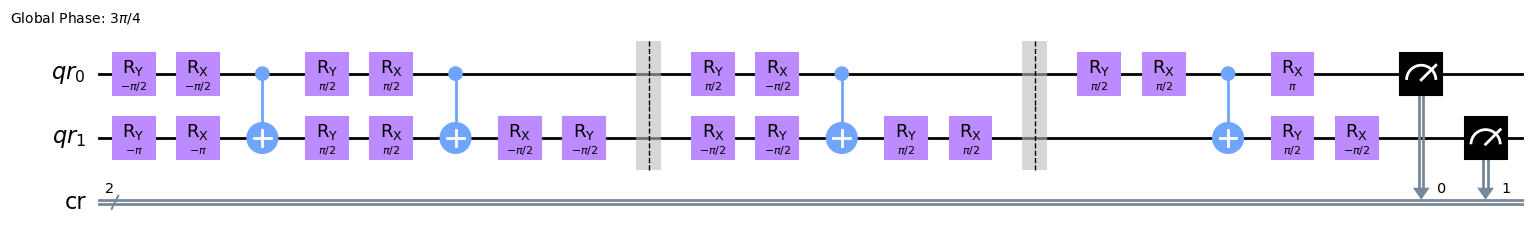

In [660]:
idx_cliff, idx_rand = 1,2
circ = rb_circs_native[idx_cliff][idx_rand]
circ.draw(output='mpl')


## Manipulate 

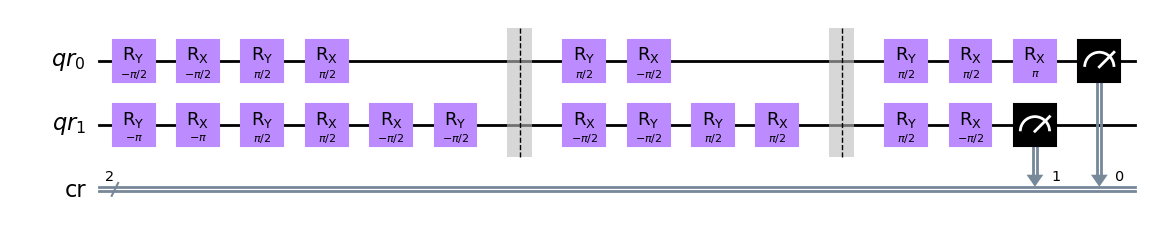

In [661]:
params['strip_cnot'] = True

if params['strip_cnot']:
    rb_circs_native = filter_gate(rb_circs_native, 'cx')
    
circ = rb_circs_native[idx_cliff][idx_rand]
circ.draw(output='mpl')

## Add reverse circuit
If the rb sequence was manipulated (eg. by filtering out CNOTs), it's not guaranteed that we return to the ground state. Append gates to enforce return to ground state.

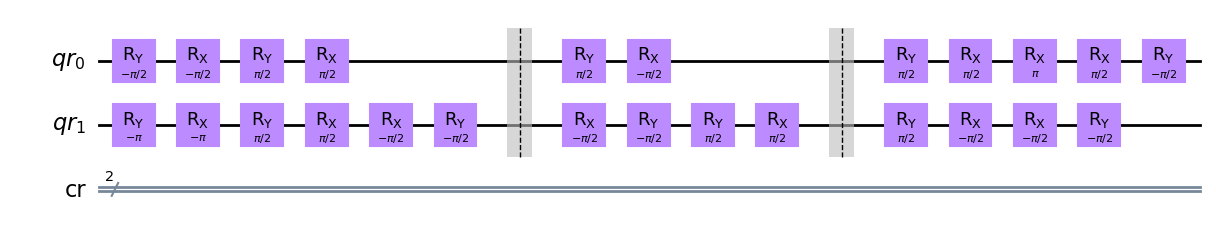

In [662]:
rb_circs_rev = []
for circ_list in rb_circs_native:
    rb_i = []
    for circ_in in circ_list:
        circ_t = append_rev_circ(circ_in)
        rb_i.append(circ_t)
        
    rb_circs_rev.append(cp.deepcopy(rb_i))
        
rb_circs_native = rb_circs_rev
#rb_circs[2][2].draw('mpl')
rb_circs_rev[idx_cliff][idx_rand].draw('mpl')

## Calc (native) gates per clifford length

In [62]:

clif_length_vector = rb_opts['length_vector']
n1q_pg = calc_1q(rb_circs_native, basis_gates=native_gates)

# count mean per idx_cliff
n1q =  np.mean(n1q_pg, axis=1)

n1q_per_cliff = np.asarray(n1q)/np.asarray(clif_length_vector)
np.mean(n1q_per_cliff)
f"native 1Q gates per clifford per qubit= {np.mean(n1q_per_cliff)/params['n_qubits']:.2f}, {n1q}/{clif_length_vector}"

'native 1Q gates per clifford per qubit= 7.38, [21.84210526 25.86842105 36.81578947 47.84210526]/[1, 2, 3, 4]'

## Simulate

In [657]:
idx_ncliff = 1  # note that rb_circs_orig has transposed indexing
idx_rand = 2
no_cx = False

def sim_circ(circ, filter_gate=''):
    # Create a new circuit without the measurement
    qregs = circ.qregs
    cregs = circ.cregs
    qc = qiskit.QuantumCircuit(*qregs, *cregs)
    for i in circ:
        if i[0].name == 'measure':
            continue
        if i[0].name != filter_gate:
            qc.data.append(i)

    
    sim = qiskit.Aer.get_backend('aer_simulator')
    basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    qc.save_unitary()
    unitary = sim.run(qc).result().get_unitary()
    
    return qc, unitary
    

def get_circ_rev(circ, filter_gate='', basis_gates=['rx', 'ry', 'cx']):
    
    qregs = circ.qregs
    cregs = circ.cregs
    
    _, unitary = sim_circ(circ, filter_gate=filter_gate)

    # calculate reverse circuit if needed
    qc_rev = qiskit.QuantumCircuit(*qregs, *cregs)
    unitary_rev = unitary.adjoint()
    qc_rev.unitary(unitary_rev, [0,1])
    circ_rev = qiskit.compiler.transpile(qc_rev, basis_gates=basis_gates)
    
    return circ_rev, unitary_rev

def append_rev_circ(circ, basis_gates=['rx', 'ry', 'cx']):
    qregs = circ.qregs
    cregs = circ.cregs
    
    circ_rev, _ = get_circ_rev(circ, basis_gates=basis_gates)
    
    qc_tot = qiskit.QuantumCircuit(*qregs, *cregs)
    for i in circ:
        if i[0].name == 'measure':
            continue
        qc_tot.data.append(i)
    
    #qc_tot.append(qiskit.circuit.Barrier(2))  # todo: fix not correctly spanned over both qubits
    for g_rev in circ_rev:
        qc_tot.data.append(g_rev)   
        
    return qc_tot


no_cx = True
filt_gate = 'cx' if no_cx else ''

# simultaion of original circuit
qc, unitary = sim_circ(rb_circs_orig[idx_rand][idx_ncliff], filter_gate=filt_gate)

# with added reversal
rb_circs_no_cnot = filter_gate(rb_circs, 'cx')
circ_sim = append_rev_circ(rb_circs_no_cnot[idx_cliff][idx_rand])
#circ_sim = rb_circs_no_cnot[idx_cliff][idx_rand]
qc, unitary = sim_circ(circ_sim)


array_to_latex(unitary, prefix="\\text{Unitary} = ")
#qc.draw('mpl')

<IPython.core.display.Latex object>

In [608]:
# this is the unitary needed to reverse
circ_rev, unitary_rev = get_circ_rev(rb_circs_orig[idx_rand][idx_ncliff], filter_gate=filt_gate)
array_to_latex(unitary_rev, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

Normally, all RB sequences come back to ground state. If we perform maniupulations (like leaving CNOTs) we have to add compensation pulses to come back at the ground state.

In [488]:
# Run simulation again with appended revese circuit
qregs = rb_circs_orig[idx_rand][idx_ncliff].qregs
cregs = rb_circs_orig[idx_rand][idx_ncliff].cregs
qc_tot = qiskit.QuantumCircuit(*qregs, *cregs)


for i in rb_circs_orig[idx_rand][idx_ncliff][0:-params['n_qubits']]:
    if no_cx:
        if i[0].name != 'cx':
            qc_tot.data.append(i)
    else:
        qc_tot.data.append(i)

for g_rev in circ_rev:
    qc_tot.data.append(g_rev)   
        
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc_tot.save_unitary()
unitary_tot = sim.run(qc_tot).result().get_unitary()

qc_tot.draw()
array_to_latex(unitary_tot, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

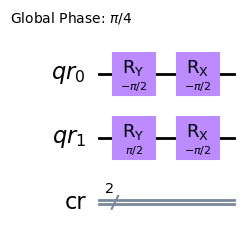

In [610]:
circ_rev.draw('mpl')

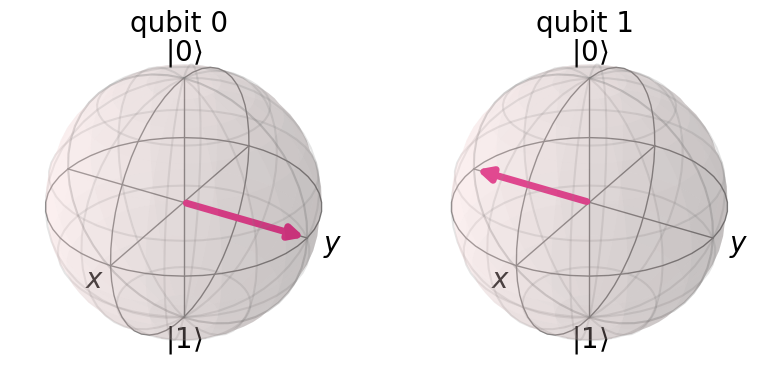

In [417]:
# effect of simulated unitary (without reversal)
from qiskit.quantum_info.states.statevector import Statevector

state_0 = Statevector([1,0,0,0])
state_out = Statevector(unitary.data.dot(state_0.data))
state_out.draw('bloch')

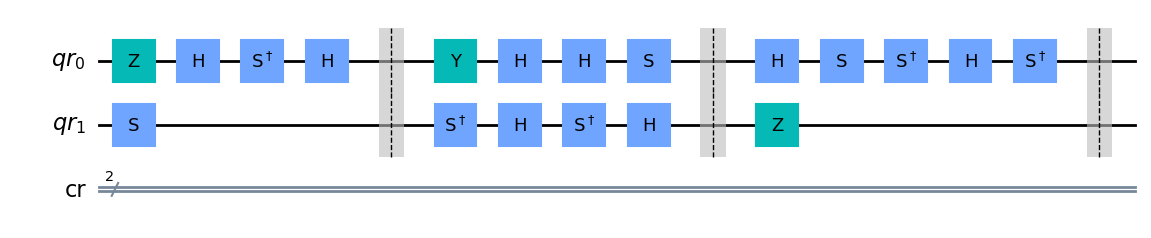

In [418]:
qc.draw('mpl')

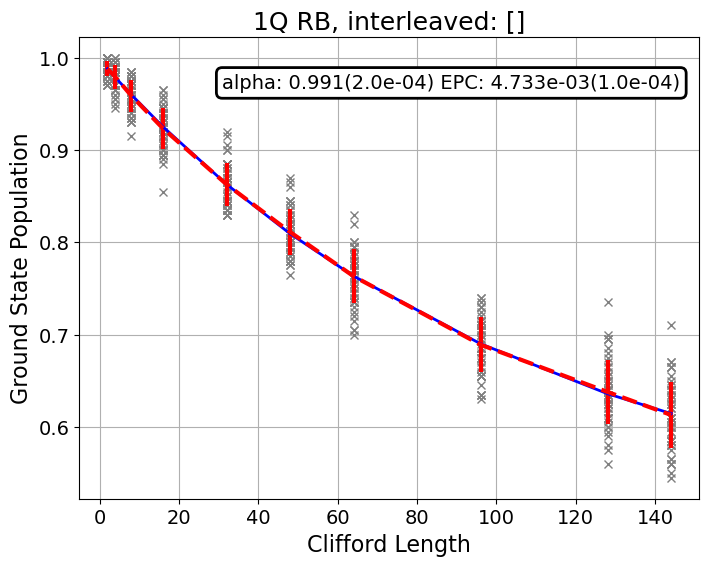

In [560]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.01 # 0.01
p2Q = 0.03

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs_orig):
    #print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    #print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    #print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
    
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title(f"{params['n_qubits']}Q RB, interleaved: {rb_opts['interleaved_gates']}", fontsize=18)

plt.show()

In [559]:
rb_fit._rb_fit_fun

<function qiskit.ignis.verification.randomized_benchmarking.fitters.RBFitter._rb_fit_fun(x, a, alpha, b)>

In [525]:
rb_fit._fit, 1-9.897e-1

([{'params': array([0.48720476, 0.98980961, 0.50658236]),
   'params_err': array([0.00680333, 0.00025956, 0.00705642]),
   'epc': 0.0050951963994844696,
   'epc_err': 0.000131118492521654}],
 0.010299999999999976)

In [399]:
job.result().get_counts()

[{'00': 175, '10': 13, '11': 5, '01': 7},
 {'00': 182, '10': 10, '11': 7, '01': 1},
 {'00': 184, '01': 7, '10': 6, '11': 3},
 {'00': 175, '01': 14, '10': 7, '11': 4}]

## Serialize to non-parallel qubit operations

Don't do 1q operations in parallel, but step by step.

In [227]:
# chose a circ
idx_order, idx_circ = 1, 217
circ = rb_circs_native[idx_order][idx_circ]

# swap qubit, as qiskit traspiles to c1not2. We want c2not1.
steps_q0, steps_q1 = circuit_2_step_list(circ, qubit_idx=0, swap_qubits=True), circuit_2_step_list(circ, qubit_idx=1, swap_qubits=True)
ser_gate_list = serialize_step_list(steps_q0, steps_q1)
ser_gate_list

[(('ry', [-1.5707963267948966]), [0]),
 (('ry', [-1.5707963267948966]), [1]),
 (('rx', [1.5707963267948966]), [0]),
 (('rx', [1.5707963267948966]), [1]),
 (('cx', []), [0, 1]),
 (('rx', [-1.5707963267948966]), [0]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [-1.5707963267948966]), [0]),
 (('ry', [-1.5707963267948966]), [1]),
 (('cx', []), [0, 1]),
 (('barrier', []), [0, 1]),
 (('rx', [1.5707963267948966]), [0]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [1.5707963267948966]), [0]),
 (('ry', [1.5707963267948966]), [1]),
 (('cx', []), [0, 1]),
 (('rx', [-1.5707963267948966]), [0]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [-1.5707963267948966]), [0]),
 (('ry', [-1.5707963267948966]), [1]),
 (('cx', []), [0, 1]),
 (('barrier', []), [0, 1]),
 (('ry', [1.5707963267948966]), [0]),
 (('ry', [-1.5707963267948966]), [1]),
 (('rx', [-1.5707963267948966]), [0]),
 (('rx', [1.5707963267948966]), [1]),
 (('measure', []), [0]),
 (('measure', []), [1])]

In [221]:
def _blocks_between_cnots(ser_gate_list):
    block_list = []
    cur_block = []
    for gate in ser_gate_list:  
        on_nv = gate[1]
        gate_name = gate[0][0]
        #print(on_nv, type(on_nv))
        if on_nv == [0,1] or gate_name== 'measure':
            block_list.append(cur_block)
            cur_block = []
        else:
            cur_block.append(gate)
            
    return block_list
        

def _has_id_gate(ser_gate_list):
    has_id = False
    idx = 0
    
    blocks_1q = _blocks_between_cnots(ser_gate_list)
    for block in blocks_1q:
        gate_length_pix = [abs(gate[0][1][0]) for gate in block]
        on_nvs = [gate[1] for gate in block]
        alt_on_nvs = [[0],[1]]*int(len(on_nvs)/2)
        
        # check if all alternating nvs
        if on_nvs != alt_on_nvs:
            has_id = True
        
        # check if parallel pulses have same length
        if not (gate_length_pix[::2] == gate_length_pix[1::2]):
            has_id = True
            
    return has_id

        
#ser_gate_list[0][1]
block = _blocks_between_cnots(ser_gate_list)[-2]
gate_length_pix = [abs(gate[0][1][0]) for gate in block]
gate_length_pix[::2] == gate_length_pix[1::2], block


_has_id_gate(ser_gate_list)
#_blocks_between_cnots(ser_gate_list)

False

In [265]:

for i in range(len(rb_circs_native)):
    for j in range(len(rb_circs_native[0])):
        try:
            circ = rb_circs_native[i][j]
        except IndexError:
            continue
        steps_q0, steps_q1 = circuit_2_step_list(circ, qubit_idx=0, swap_qubits=True), circuit_2_step_list(circ, qubit_idx=1, swap_qubits=True)
        ser_gate_list = serialize_step_list(steps_q0, steps_q1)
        if not _has_id_gate(ser_gate_list):
            print(i, j)
        

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
7 0
7 1
7 2


## Save to file

Iterate over (converted to native gates) gate sequence and create a qudi compatible sequence as a json file.

In [664]:
qudi_gates = []
idx = 0


n_seqs = len(rb_circs_native[0])*len(rb_circs_native)
for idx_cl, circ_list in enumerate(rb_circs_native):
    circs_i = []
    for idx_r, circ in enumerate(circ_list):
        #circs_i.append()
        # swap qubit, as qiskit traspiles to c1not2. We want c2not1.
        steps_q0 = circuit_2_step_list(circ, qubit_idx=0, swap_qubits=True)
        steps_q1 = circuit_2_step_list(circ, qubit_idx=1, swap_qubits=True)
        
        idx_dict = {"idx_info":{"n_cliff": rb_opts['length_vector'][idx_cl],
                    "idx_cliff": idx_cl,
                    "idx_random": idx_r}}
        params_dict = {"script params": params}
        
        header = f"### Benchmark Sequence {idx+1}/{n_seqs} ###\n"
        header += f"# {json.dumps(idx_dict)}"
        header += f"# {json.dumps(params)}"
        header += f"# Columns: operation | params | idx_qubit\n"

        
        
        steps = [header]
        steps.append(serialize_step_list(steps_q0, steps_q1))
        
        circs_i.append(steps)
        idx += 1
        
    qudi_gates.append(circs_i)
    

In [84]:
qudi_gates[0]

[['### Benchmark Sequence 1/152 ###\n# {"idx_info": {"n_cliff": 1, "idx_cliff": 0, "idx_random": 0}}# {"n_qubits": 2, "force_n_cx_const": true, "timestamp": "20230217-1031-37", "qiskit_version": "0.19.1", "rb_options": {"length_vector": [1, 2, 3, 4], "nseeds": 150, "rb_pattern": [[0, 1]], "interleaved_gates": [], "length_multiplier": 1}}# Columns: operation | params | idx_qubit\n',
  [(('ry', [1.5707963267948966]), [1]),
   (('rx', [3.141592653589793]), [1]),
   (('cx', []), [0, 1]),
   (('ry', [1.5707963267948966]), [1]),
   (('rx', [1.5707963267948966]), [1]),
   (('cx', []), [0, 1]),
   (('barrier', []), [0, 1]),
   (('cx', []), [0, 1]),
   (('rx', [-1.5707963267948966]), [1]),
   (('ry', [-1.5707963267948966]), [1]),
   (('cx', []), [0, 1]),
   (('ry', [1.5707963267948966]), [1]),
   (('rx', [3.141592653589793]), [1]),
   (('measure', []), [1])]],
 ['### Benchmark Sequence 2/152 ###\n# {"idx_info": {"n_cliff": 1, "idx_cliff": 0, "idx_random": 1}}# {"n_qubits": 2, "force_n_cx_const"

Perform the saving

In [665]:
import json

fname = f"{params['timestamp']}_rb_seq_{params['n_qubits']}q"
#fname += "_only_nv=2"
if is_interleaved(rb_opts):
    fname += "_int"
if params['force_n_cx_const']:
    fname += "_ncxfix"
if params['strip_cnot']:
    fname += '_noCNOT'
    
fname += ".json"
    
with open(fname, 'w') as f:
    json.dump(qudi_gates, f, indent=None)
fname

'20230220-1057-17_rb_seq_2q_ncxfix_noCNOT.json'

Load saved file to check.

# Load and Analyze 

In [626]:
fname = '20230202-1815-55_rb_seq_2q_ncxfix.json'
fname = '20230202-1138-34_rb_seq_1q.json'
#fname = '20230206-0849-14_rb_seq_2q_ncxfix.json'
fname = '20230206-0849-14_rb_seq_2q_ncxfix.json'  # 2q, no cnot
#fname = '20230213-1230-17_rb_seq_1q.json' # 1q simult
fname = '20230217-1031-37_rb_seq_2q_ncxfix.json'
fname = '20230220-1031-36_rb_seq_2q_ncxfix_noCNOT.json'

with open(fname) as f:
    qudi_gates = json.load(f)
    
qudi_gates[2][-1]

['### Benchmark Sequence 117/156 ###\n# {"idx_info": {"n_cliff": 3, "idx_cliff": 2, "idx_random": 38}}# {"n_qubits": 2, "force_n_cx_const": true, "timestamp": "20230220-1031-36", "qiskit_version": "0.19.1", "rb_options": {"length_vector": [1, 2, 3, 4], "nseeds": 150, "rb_pattern": [[0, 1]], "interleaved_gates": [], "length_multiplier": 1}, "strip_cnot": true}# Columns: operation | params | idx_qubit\n',
 [[['ry', [-1.5707963267948966]], [1]],
  [['rx', [1.5707963267948966]], [1]],
  [['rx', [-1.5707963267948966]], [1]],
  [['ry', [-1.5707963267948966]], [1]],
  [['barrier', []], [0, 1]],
  [['ry', [1.5707963267948966]], [1]],
  [['rx', [-1.5707963267948966]], [1]],
  [['ry', [1.5707963267948966]], [1]],
  [['rx', [1.5707963267948966]], [1]],
  [['barrier', []], [0, 1]],
  [['ry', [1.5707963267948966]], [1]],
  [['rx', [3.141592653589793]], [1]],
  [['rx', [-1.5707963267948966]], [1]],
  [['ry', [-1.5707963267948966]], [1]],
  [['barrier', []], [0, 1]],
  [['rx', [-1.5707963267948983]],

## Check state in sequence / after init

In [627]:
def get_idx_first_cx(qudi_gates):
    is_cx = np.asarray([gate[0][0]=='cx' for gate in qudi_gates[1]])
    idx_first_cx = np.argwhere(is_cx)[0][0] 
    
    return idx_first_cx

def create_qc_from_qudi(qudi_gates, idx_cut=None):
    # todo: ugly way to create correct qiskit quantum register
    
    rb_opts['length_vector'] = [1]
    rb_opts['nseeds'] = 150
    rb_opts['rb_pattern'] = [[0,1]] if params['n_qubits']==2 else [[0]]
    
    rb_circs, _ = rb.randomized_benchmarking_seq(**rb_opts)
    
    qregs = rb_circs[0][0].qregs
    cregs = rb_circs[0][0].cregs
    qc = qiskit.QuantumCircuit(*qregs, *cregs)

    for idx, gate in enumerate(qudi_gates[1]):
        add_qudi_gate(qc, gate, swap_qubits=False, mirror_1q=False)
        if idx_cut:
            if idx_cut == idx:
                break
                
    return qc

0

0

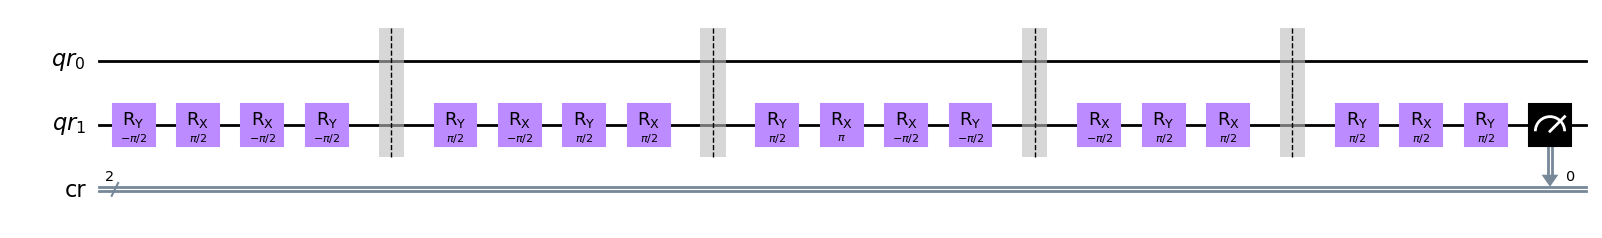

In [628]:
idx_ncliff = 3
idx_rand = 1
#idx_cut =  get_idx_first_cx(qudi_gates[idx_ncliff][idx_rand]) -1
#idx_cut =  get_idx_first_cx(qudi_gates[idx_ncliff][idx_rand])    # after 1st CNOT
idx_cut = None

qc = create_qc_from_qudi(qudi_gates[idx_ncliff][idx_rand], idx_cut=idx_cut)
qc.draw('mpl')

In [313]:
n1q_pg[idx_ncliff][idx_rand]

32.0

In [300]:
clif_length_vector = [2, 4, 8, 16, 32, 48, 64, 96, 128, 144] #  [1, 2, 3, 4]#
clif_length_vector =   [1, 2, 3, 4]#
#n1q_pg = get_n_1q_rot(qc, basis_gates=['rx', 'ry'])
n1q_pg = calc_1q(qudi_gates, basis_gates=['rx', 'ry'])

# count mean, median Cnots per idx_cliff
n1q =  np.mean(n1q_pg, axis=1)
qudi_gates[0][0][0]

n1q_per_cliff = np.asarray(n1q)/np.asarray(clif_length_vector)
np.mean(n1q_per_cliff),  n1q, qudi_gates[0][0][0],

(10.8125,
 array([12.82352941, 22.14705882, 30.52941176, 36.70588235]),
 '### Benchmark Sequence 1/136 ###\n# {"idx_info": {"n_cliff": 1, "idx_cliff": 0, "idx_random": 0}}# {"n_qubits": 2, "force_n_cx_const": true, "timestamp": "20230206-0849-14", "qiskit_version": "0.19.1", "rb_options": {"length_vector": [1, 2, 3, 4], "nseeds": 150, "rb_pattern": [[0, 1]], "interleaved_gates": []}}# Columns: operation | params | idx_qubit\n')

In [285]:
n1q

array([12.82352941, 22.14705882, 30.52941176, 36.70588235])

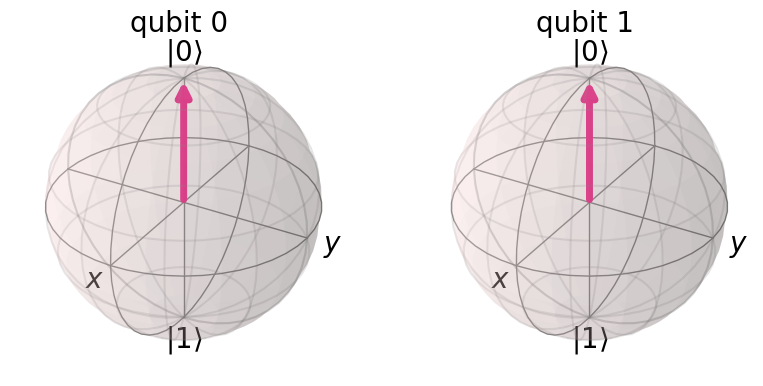

In [427]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector

sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['rx','ry','id','cx'] # use U,CX for now
qc.save_statevector()
#qc.save_unitary()
#unitary = sim.run(qc).result().get_unitary()
out_vec = sim.run(qc).result().get_statevector()

from qiskit.visualization import array_to_latex
array_to_latex(out_vec, prefix="\\text{Out_vec} = ")

plot_state_city(out_vec)
plot_bloch_multivector(out_vec)

In [303]:
from qiskit.quantum_info import entanglement_of_formation, partial_trace
import qiskit.opflow as ops_sigma

entanglement_of_formation(out_vec)
ops_sigma.Z

PauliOp(Pauli('Z'), coeff=1.0)

## Plot target, control in superposition before 1st CNOT

In [344]:
def state_on_qubit_equator(vector, qubit=0):
    
    idx_subsys = 0 if qubit==1 else 1
    if qubit > 1:
        raise NotImplementedError
    
    vec_len =  np.real(partial_trace(vector, [idx_subsys]).purity())
    vec_z = partial_trace(vector, [idx_subsys]).expectation_value(ops_sigma.Z)
    is_on_eq = np.isclose(vec_len, 1) and np.isclose(vec_z, 0)
    
    return is_on_eq
    
state_on_qubit_equator(out_vec, qubit=1)

True

In [360]:
from qiskit.quantum_info import entanglement_of_formation
entanglement_of_formation(out_vec)

idx_ncliff = 0

sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['rx','ry','id','cx'] 

x_axis, y_eq = [], []
for idx, qd_gates in enumerate(qudi_gates[idx_ncliff]):  
    idx_cut =  get_idx_first_cx(qd_gates) - 1
    qc = create_qc_from_qudi(qd_gates, idx_cut=idx_cut)

    qc.save_statevector()
    out_vec = sim.run(qc).result().get_statevector()
    eq_1 = state_on_qubit_equator(out_vec, qubit=0)
    eq_2 = state_on_qubit_equator(out_vec, qubit=1)
    eq_both = eq_1 and eq_2
    y = 0
    if eq_1:
        y = 1
    if eq_2:
        y = 2
    if eq_both:
        y = 3
    
    x_axis.append(idx)
    y_eq.append(y)
    



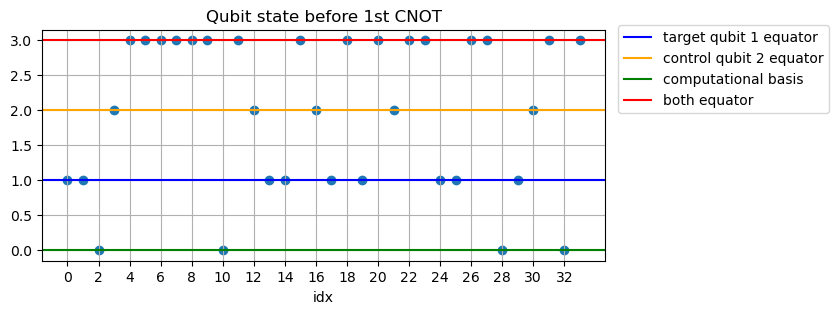

In [371]:

plt.figure(figsize=(16,3))
ax = plt.subplot(121)

#plt.plot(x_axis, np.asarray(y_eq))
plt.scatter(x_axis, np.asarray(y_eq))
plt.axhline(1, label='target qubit 1 equator', color='blue')
plt.axhline(2, label='control qubit 2 equator', color='orange')
plt.axhline(0, label='computational basis', color='green')
plt.axhline(3, label='both equator', color='red')

plt.xticks(x_axis[::2])
plt.xlabel("idx")
plt.grid()
plt.title("Qubit state before 1st CNOT")

ax.legend(bbox_to_anchor=(1.01, 1.05))

## Plot entanglement after 1st CNOT

Rand benchmarking sequences that create entanglement might be more prone to errors.

In [265]:
from qiskit.quantum_info import entanglement_of_formation
entanglement_of_formation(out_vec)

idx_ncliff = 0

sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['rx','ry','id','cx'] # use U,CX for now

x_axis, y_ent = [], []
for idx, qd_gates in enumerate(qudi_gates[idx_ncliff]):  
    idx_cut =  get_idx_first_cx(qd_gates) 
    qc = create_qc_from_qudi(qd_gates, idx_cut=idx_cut)

    qc.save_statevector()
    out_vec = sim.run(qc).result().get_statevector()
    x_axis.append(idx)
    y_ent.append(entanglement_of_formation(out_vec))
    



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


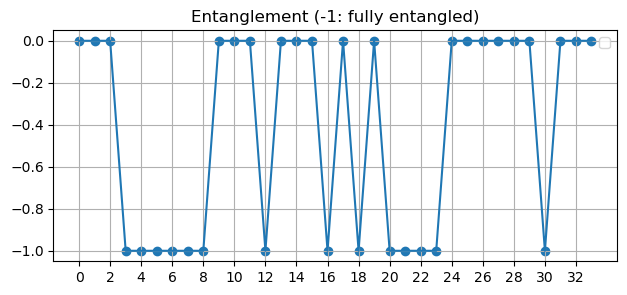

In [267]:

plt.figure(figsize=(16,3))
plt.subplot(121)

plt.plot(x_axis, -np.asarray(y_ent))
plt.scatter(x_axis, -np.asarray(y_ent))
plt.xticks(x_axis[::2])

plt.xlabel("idx")
plt.grid()
plt.title("Entanglement (-1: fully entangled)")
plt.legend()

## Plot number of 1q, 2q gates for same n_cliff

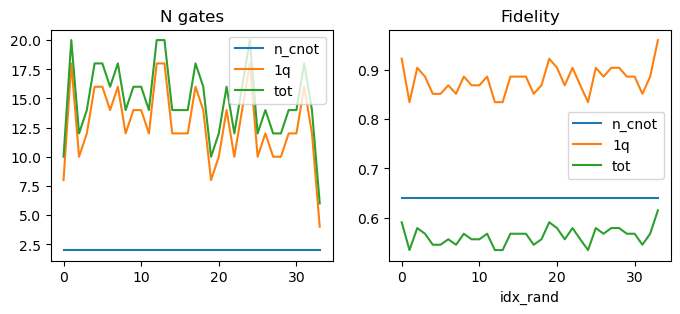

array([ 8, 18, 10, 12, 16, 16, 14, 16, 12, 14, 14, 12, 18, 18, 12, 12, 12,
       16, 14,  8, 10, 14, 10, 14, 18, 10, 12, 10, 10, 12, 12, 16, 12,  4])

In [101]:
err_rate_1q = 0.99
err_rate_2q = 0.8

idx_cliff = 0
ys_cx, ys_1q = [], []
for idx_rand, circ in enumerate(qudi_gates[idx_cliff]):
    y_cx, y_1q = get_n_cx(circ), get_n_1q_rot(circ)
    ys_cx.append(y_cx)
    ys_1q.append(y_1q)
    
ys_cx, ys_1q = np.asarray(ys_cx), np.asarray(ys_1q)

plt.figure(figsize=(8,3))
plt.subplot(121)

plt.plot(ys_cx, label='n_cnot')
plt.plot(ys_1q, label='1q')
plt.plot(np.asarray(ys_1q)+np.asarray(ys_cx), label='tot')
plt.title("N gates")
plt.legend()

plt.subplot(122)
plt.plot(err_rate_2q**ys_cx, label='n_cnot')
plt.plot(err_rate_1q**ys_1q, label='1q')
plt.plot((err_rate_1q**ys_1q * err_rate_2q**ys_cx)/1, label='tot')
plt.title("Fidelity")
plt.legend()

plt.xlabel("idx_rand")
plt.show()

ys_1q

In [322]:
err_rate_1q**ys_cx, err_rate_2q**ys_cx

(array([0.96059601, 0.96059601, 0.96059601, 0.9801    , 0.96059601,
        0.96059601, 0.96059601, 0.9801    , 0.9801    , 1.        ]),
 array([0.4096, 0.4096, 0.4096, 0.64  , 0.4096, 0.4096, 0.4096, 0.64  ,
        0.64  , 1.    ]))

In [313]:
qudi_gates[idx_cliff][0][1]

[[['rx', [1.5707963267948966]], [0]],
 [['rx', [3.141592653589793]], [1]],
 [['ry', [1.5707963267948966]], [0]],
 [['cx', []], [0, 1]],
 [['rx', [-1.5707963267948966]], [0]],
 [['rx', [-1.5707963267948966]], [1]],
 [['ry', [-1.5707963267948966]], [0]],
 [['ry', [-1.5707963267948966]], [1]],
 [['barrier', []], [0, 1]],
 [['ry', [1.5707963267948966]], [0]],
 [['ry', [1.5707963267948966]], [1]],
 [['rx', [1.5707963267948966]], [0]],
 [['rx', [1.5707963267948966]], [1]],
 [['cx', []], [0, 1]],
 [['ry', [-1.5707963267948966]], [0]],
 [['rx', [3.141592653589793]], [1]],
 [['rx', [-1.5707963267948966]], [0]],
 [['measure', []], [1]],
 [['measure', []], [0]]]

In [304]:
qudi_gates[idx_cliff][1][1]

[[['rx', [3.141592653589793]], [0]],
 [['rx', [-1.5707963267948966]], [1]],
 [['ry', [1.5707963267948961]], [1]],
 [['cx', []], [0, 1]],
 [['rx', [-1.5707963267948966]], [0]],
 [['ry', [1.5707963267948966]], [1]],
 [['ry', [-1.5707963267948966]], [0]],
 [['rx', [1.5707963267948966]], [1]],
 [['barrier', []], [0, 1]],
 [['ry', [1.5707963267948966]], [0]],
 [['rx', [-1.5707963267948966]], [1]],
 [['rx', [1.5707963267948966]], [0]],
 [['ry', [-1.5707963267948966]], [1]],
 [['cx', []], [0, 1]],
 [['rx', [3.141592653589793]], [0]],
 [['ry', [-1.5707963267948966]], [1]],
 [['measure', []], [0]],
 [['rx', [1.5707963267948966]], [1]],
 [['measure', []], [1]]]

# Playground

In [509]:
pulse = qiskit.pulse.Drag(100, 1, 25, 0.01) # duration, amp, sigma, beta

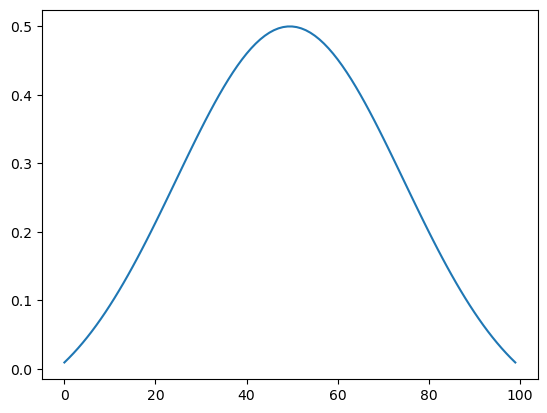

In [508]:
plt.plot(pulse.get_waveform().samples)
plt.show()